Some preliminary code:

In [46]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

For reference, here's your original image:

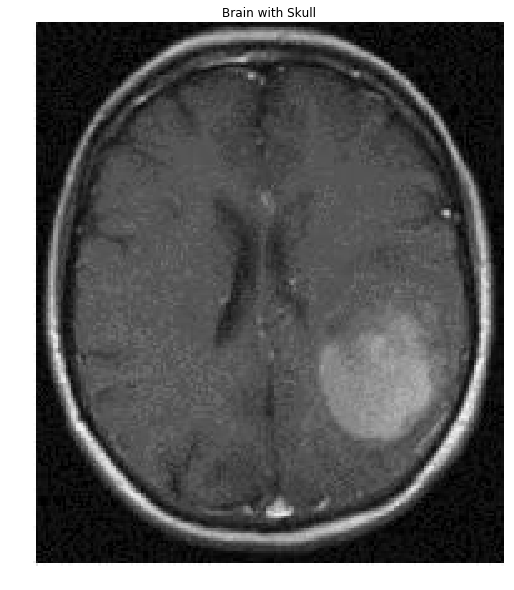

In [47]:
#Read in image
img           = cv2.imread('brain2.png')
gray          = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Brain with Skull',gray,'gray')

If the pixels in the image can be classified into two different intensity classes, that is, if they have a bimodal histogram, then [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) can be used to threshold them into a binary mask. Let's check that assumption.

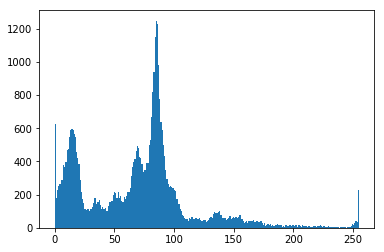

In [48]:
    #Make a histogram of the intensities in the grayscale image
    plt.hist(gray.ravel(),256)
    plt.show()

Okay, the data is nicely bimodal. Let's apply the threshold and see how we do.

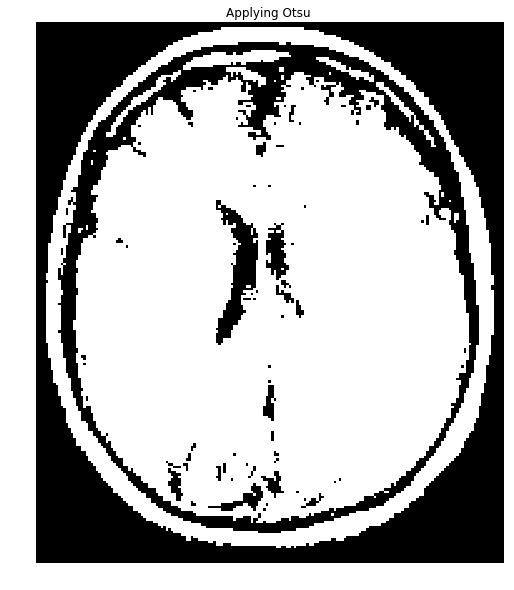

In [90]:
#Threshold the image to binary using Otsu's method
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Applying Otsu',thresh,'gray')

Things are easier to see if we overlay our mask onto the original image

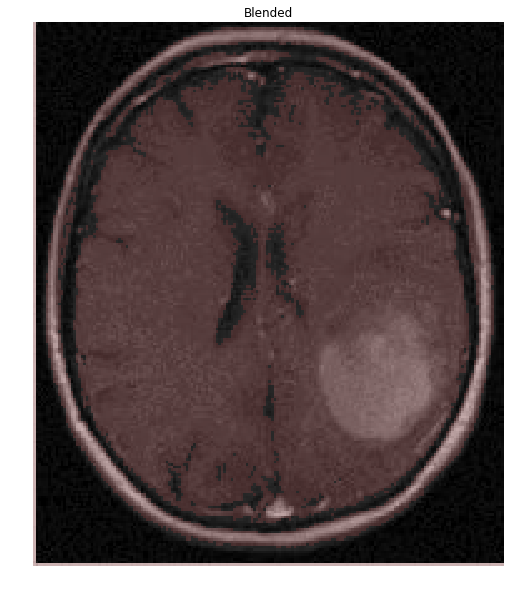

In [51]:
colormask = np.zeros(img.shape, dtype=np.uint8)
colormask[thresh!=0] = np.array((0,0,255))
blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
ShowImage('Blended', blended, 'bgr')

The overlap of the brain (shown in red) with the mask is so perfect, that we'll stop right here. To do so, let's extract the connected components and find the largest one, which will be the brain.

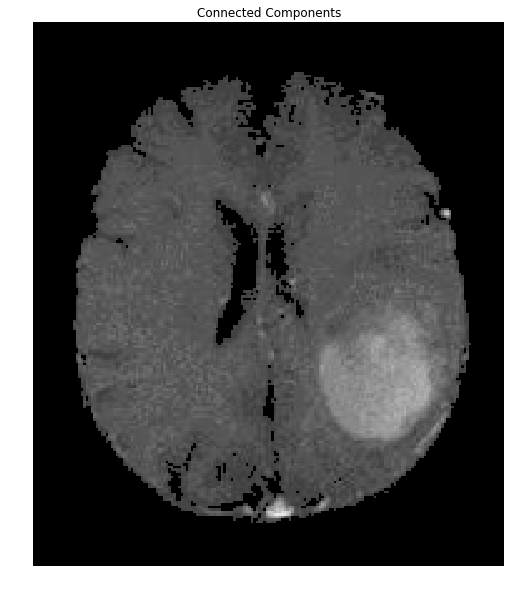

In [52]:
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
#Get pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
ShowImage('Connected Components',brain_out,'rgb')

Running this again with your second image produces a mask with many holes:

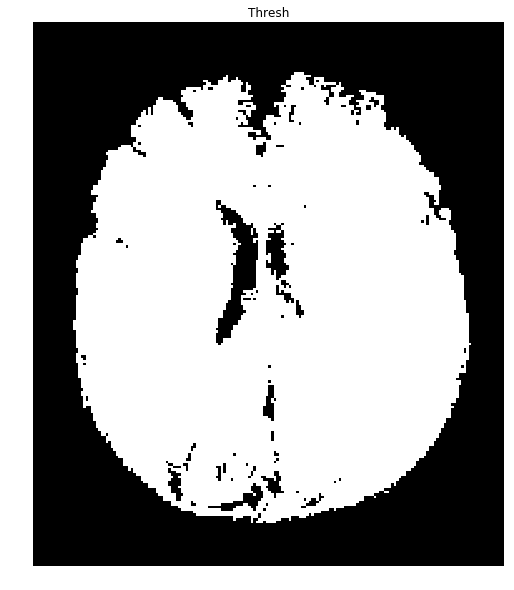

In [54]:
ShowImage('Thresh', brain_mask, 'gray')

We can close many of these holes using a [closing transformation](https://en.wikipedia.org/wiki/Closing_(morphology)):

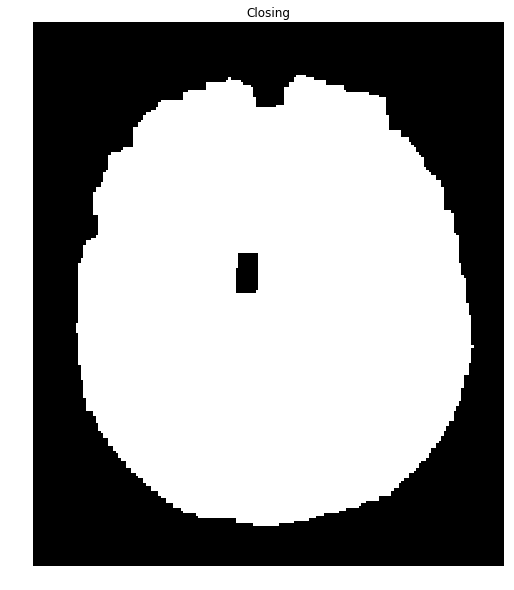

In [62]:
brain_mask = np.uint8(brain_mask)
kernel = np.ones((8,8),np.uint8)
closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
ShowImage('Closing', closing, 'gray')

In [ ]:
brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[closing==False] = (0,0,0)
ShowImage('Connected Components',brain_out,'rgb')

An alternative approach is to use a watershed transform. To begin, we'll shrink the region labeled as brain+skull a few iterations.

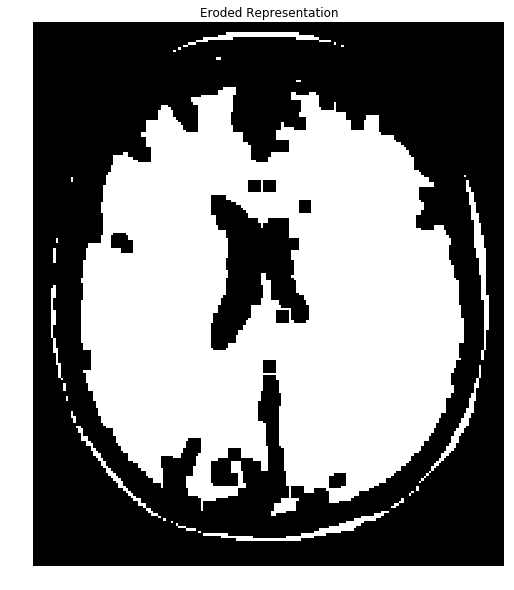

In [85]:
kernel = np.ones((3,3),np.uint8)

#Shrink the labeled regions by a few iterations
#WE ASSUME that this creates a hole between the skull and the brain
brain_erode = cv2.erode(thresh, kernel, iterations=2)

ShowImage('Eroded Representation',brain_erode,'gray')

If the foregoing has opened holes in the brain, we'll want to fill those in. If we've created a hole between the brain and the skull, then this is easy: we'll use a floodfill to find all of those background areas that are not in the middle of the brain, invert the mask, and then apply it to fill in the holes.

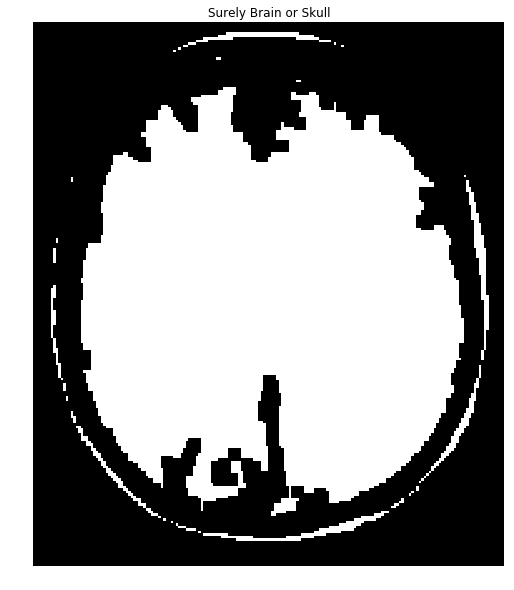

In [87]:
im_floodfill = brain_erode.copy()
 
#Mask used for flood filling; we make it slightly larger than the original image
h, w = surely_brain_or_skull.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
#Perform the flood fill
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
#Invert floodfilled image: Now the white areas correspond to the interior of the brain
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
#Fill in the brain's interior
surely_brain_or_skull = brain_erode | im_floodfill_inv

ShowImage('Surely Brain or Skull',surely_brain_or_skull,'gray')

Now we find the areas about which we are uncertain as to whether they are brain or not:

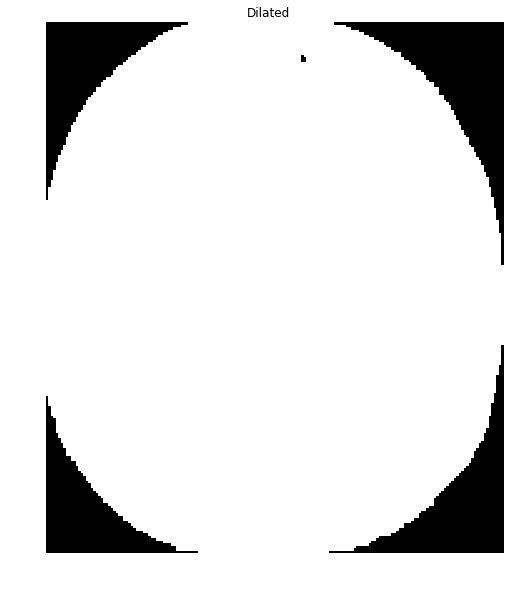

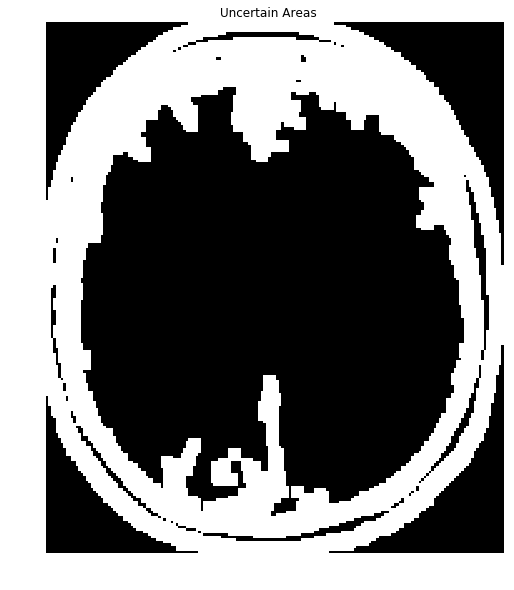

In [97]:
dilated = cv2.dilate(thresh, kernel, iterations=4)
ShowImage('Dilated',dilated,'gray')
uncertain          = dilated - surely_brain_or_skull
ShowImage('Uncertain Areas',uncertain,'gray')

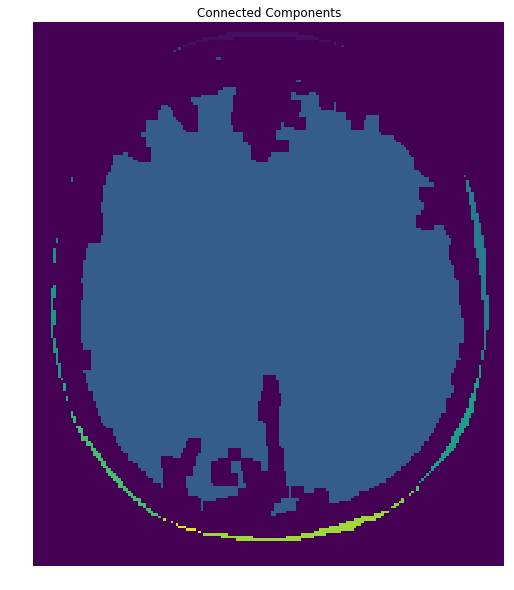

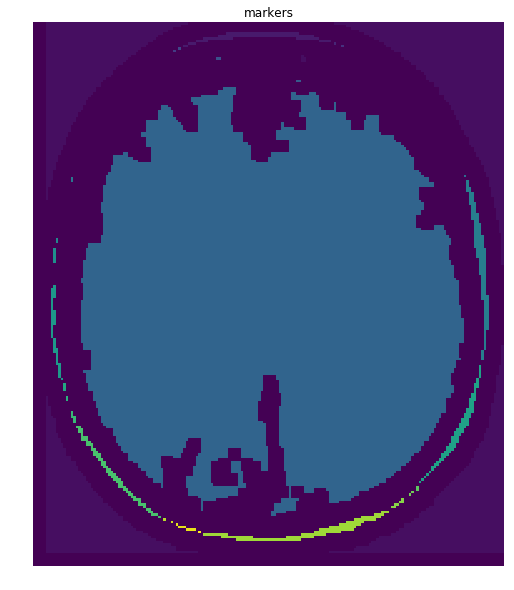

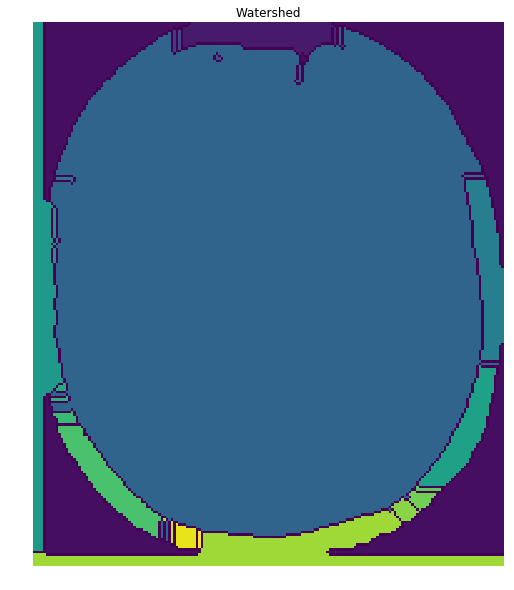

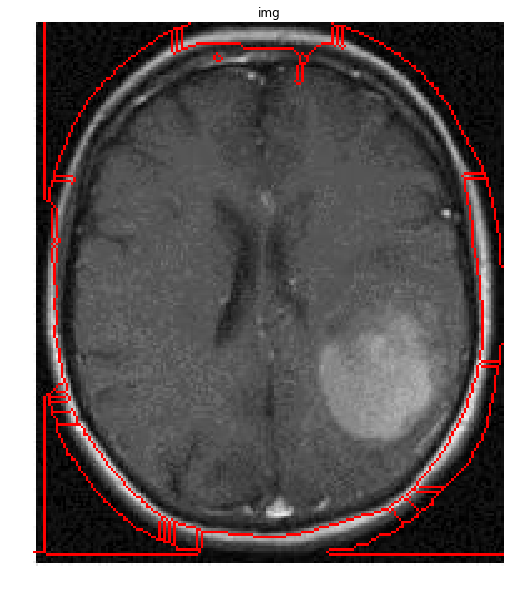

In [102]:
#Label the brain, the skull, and any other such components
ret, markers = cv2.connectedComponents(surely_brain_or_skull)
ShowImage('Connected Components',markers,'rgb')

#Add one to all labels so that areas which are surely background are not 0, but 1
markers = markers+1

#Mark the uncertain regions with zero
markers[uncertain==np.max(uncertain)] = 0

ShowImage('markers',markers,'rgb')

dist    = cv2.distanceTransform(dilated,cv2.DIST_L2,5)
markers = skwater(-dist,markers,watershed_line=True)

ShowImage('Watershed',markers,'rgb')
imgout = img.copy()
imgout[markers == 0] = [0,0,255] #Label the watershed_line

ShowImage('img',imgout,'bgr')